In [ ]:
!pip install retina-face
from keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import load_model
from tensorflow.keras.optimizers import Adagrad
from retinaface import RetinaFace
from keras.layers import BatchNormalization
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from google.colab import drive
from sklearn.model_selection import train_test_split

# Monto Google Drive en el entorno de Google Colab
drive.mount('/content/drive')

# Defino un punto de control para guardar el modelo
checkpoint_path = '/content/drive/My Drive/Checkpoints/model_checkpoint_resnet_BB.h5'

In [ ]:
# Crear el modelo base ResNet50 preentrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas base
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas adicionales para la clasificación binaria
model = Sequential()
model.add(base_model)
#model.add(GlobalAveragePooling2D())
model.add(layers.Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)
#model = load_model(checkpoint_path)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',metrics=['accuracy', 'Recall'])

# Configurar generadores de datos para el entrenamiento
batch_size = 16

data_dir = '/content/drive/My Drive/Dataset_2_ext/'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    validation_split=0.2  # Proporción para validación
)

# ImageDataGenerator para conjunto de validación sin aumento
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

# Generadores de datos
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True  # Mezclar los datos en el conjunto de entrenamiento
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True  # No es necesario mezclar los datos en el conjunto de validación
)

# Entrenar el modelo
epochs = 20

history = model.fit(train_generator, epochs=epochs ,validation_data=validation_generator , callbacks=[checkpoint], initial_epoch=0)

94765736/94765736 [==============================] - 5s 0us/step
Found 6851 images belonging to 2 classes.
Found 1711 images belonging to 2 classes.
Epoch 1/10
429/429 [==============================] - 3985s 9s/step - loss: 0.6352 - accuracy: 0.7250 - recall: 0.7217 - val_loss: 0.3985 - val_accuracy: 0.8112 - val_recall: 0.7344
Epoch 2/10
429/429 [==============================] - 140s 325ms/step - loss: 0.4998 - accuracy: 0.7754 - recall: 0.7777 - val_loss: 0.3213 - val_accuracy: 0.8416 - val_recall: 0.8467
Epoch 3/10
429/429 [==============================] - 135s 314ms/step - loss: 0.4549 - accuracy: 0.7921 - recall: 0.7988 - val_loss: 0.3327 - val_accuracy: 0.8551 - val_recall: 0.8433
Epoch 4/10
429/429 [==============================] - 140s 326ms/step - loss: 0.4533 - accuracy: 0.7940 - recall: 0.7977 - val_loss: 0.3036 - val_accuracy: 0.8568 - val_recall: 0.8800
Epoch 5/10
429/429 [==============================] - 134s 311ms/step - loss: 0.4312 - accuracy: 0.8100 - recall: 0.8

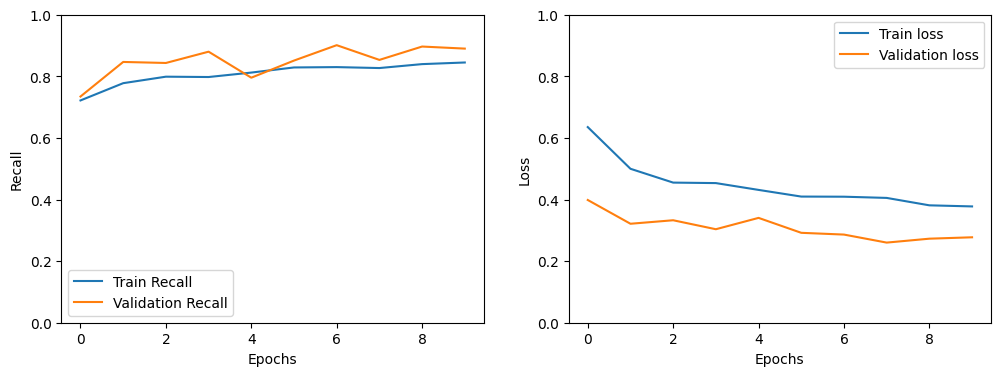

In [ ]:
train_recall = history.history['recall']
val_recall = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']


# Graficar las curvas de precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_recall, label='Train Recall')
plt.plot(val_recall, label='Validation Recall')
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/VPC_2/mi_modelo_resnet.keras')

In [ ]:
#Cargo el modelo
model= load_model('/content/drive/My Drive/Saved_model_resnet/mi_modelo_resnet_BB2.keras')

In [ ]:
#Defino función de predicción
def prediccion(modelo,imagen,treshold):

     # Reshape para que coincida con el formato de entrada del modelo

      nueva_altura = 224
      nuevo_ancho = 224

      # Extraer caras con RetinaFace
      faces = RetinaFace.extract_faces(imagen, threshold=0.8)

      # Verificar si se detectó al menos una cara
      if len(faces) == 0:
        return "No se detectaron caras en la imagen"

      # Tomar la primera cara detectada (asumiendo que solo hay una)
      face = faces[0]

      h, w = face.shape[:2]


      # Calcular el nuevo tamaño manteniendo la relación de aspecto original
      factor_redimensionamiento = min(nueva_altura / h, nuevo_ancho / w)
      nueva_altura_temp = int(h * factor_redimensionamiento)
      nuevo_ancho_temp = int(w * factor_redimensionamiento)

      # Redimensionar la cara manteniendo la relación de aspecto
      cara_redimensionada = cv2.resize(face, (nuevo_ancho_temp, nueva_altura_temp))

      cara_redimensionada =tf.keras.applications.resnet50.preprocess_input(cara_redimensionada)

      # Crear una imagen en blanco del tamaño objetivo
      imagen_final = np.zeros((nueva_altura, nuevo_ancho, 3), dtype=np.uint8)

      # Calcular las coordenadas para copiar la cara redimensionada en el centro
      y_offset = (nueva_altura - nueva_altura_temp) // 2
      x_offset = (nuevo_ancho - nuevo_ancho_temp) // 2

      # Copiar la región redimensionada en la ubicación calculada
      imagen_final[y_offset:y_offset + nueva_altura_temp, x_offset:x_offset + nuevo_ancho_temp] = cara_redimensionada

      imagen_final = tf.expand_dims(imagen_final, axis=0)


      # Realizar predicciones
      prediccion_imagen = modelo.predict(imagen_final)


      if prediccion_imagen > treshold:
            print(prediccion_imagen)
            return "La persona tiene sueño"
      else:
            print(prediccion_imagen)
            return "La persona no tiene sueño"



In [ ]:
def face_detection(image,etiqueta):

    #Leo la imagen y detecto rostro
    faces = RetinaFace.detect_faces(image, threshold = 0.8)

    for face_key, face_info in faces.items():
        facial_area = face_info['facial_area']

    # Acceder a las coordenadas específicas
    x, y, width, height = facial_area

    # Dibujo el bounding box en la imagen original con la mejor coincidencia
    top_left = (x,y)
    bottom_right = (width, height)
    cv2.rectangle(image,(top_left),(bottom_right) , (0, 0, 255),2)

    final_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return  final_image

In [ ]:
#Cargo imágenes a testear

# Directorio en Google Drive que contiene las imágenes
directorio_drive = '/content/drive/My Drive/Imágenes de prueba/Con sueño'

# Obtener la lista de nombres de archivos en el directorio
nombres_archivos = os.listdir(directorio_drive)

# Filtrar solo los archivos de imagen (puedes ajustar según los tipos de archivos que tengas)
extensiones_imagen = ['.jpg', '.jpeg', '.png']
rutas_imagenes = [os.path.join(directorio_drive, archivo) for archivo in nombres_archivos if any(archivo.lower().endswith(ext) for ext in extensiones_imagen)]

imagenes = [cv2.imread(ruta) for ruta in rutas_imagenes]

#Realizo predicciones
for imagen, ruta in zip(imagenes, rutas_imagenes):
    # Realizar la predicción
    pred = prediccion(model, imagen, 0.9)

    face = face_detection(imagen, pred)

    # Mostrar la imagen con el resultado de la predicción
    plt.imshow(face)
    plt.title(f"Predicción:{pred}")
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.